In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
#from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

#import sys 
#sys.path.insert(0, './Onedrive/Project-T2/PointNetJJ')
#from spheres_JJ import sphere_generator

class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(k)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        #x = F.relu(self.bn6(self.dropout(x)))
        x = self.bn6(self.dropout(x))
        return x #F.log_softmax(x, dim=1)
   
###########################################################    
# Training
nclouds = 20000
npoints = 100

multip = [5/k for k in range(1,31)]
def shaker(vect):
    k = 0
    for i in range(len(vect)):
        vect[i] *= multip[k]
        k += 1
        k = k % 30
    return vect

# The point clouds
normal = torch.randn(nclouds, npoints, 1)
normal = shaker(normal)
uniform = torch.rand(nclouds, npoints, 1) - 0.5
uniform = shaker(uniform)

trainset = torch.cat((normal, uniform))

# Function to calculate Q
R=0.05
def charfun(x,y, R):
    if abs(x-y) <= R:
        return 1
    return 0
labels = []
for x in trainset.view(-1,npoints).detach().numpy():
    labels.append(1/(len(x)**2) * sum(charfun(k, j, R) for k in x for j in x))

labels = torch.tensor(labels).view(-1,1)
# Labels
#zeros = torch.zeros(nclouds, dtype=torch.float)
#ones = torch.ones(nclouds, dtype=torch.float)
#labels = torch.cat((zeros, ones))

dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                          shuffle=True, num_workers=2, drop_last=True)

#########################################################
# Testing clouds

ncloudstest = 1000
npointstest = 100

# The point clouds
normaltest = torch.randn(ncloudstest, npointstest, 1)
uniformtest = torch.rand(ncloudstest, npointstest, 1) - 0.5
normaltest = shaker(normaltest)
uniformtest = shaker(uniformtest)

testset = torch.cat((normaltest, uniformtest))

labels_test = []
for x in testset.view(-1,npoints).detach().numpy():
    labels_test.append(1/(len(x)**2) * sum(charfun(k, j, R) for k in x for j in x))

testlabels = torch.tensor(labels_test).view(-1,1)
# Labels
#testzeros = torch.zeros(ncloudstest, dtype=torch.float)
#testones = torch.ones(ncloudstest, dtype=torch.float)
#testlabels = torch.cat((testzeros, testones))
#print(labels.view(-1,2).size())
test=testset

testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last=True)

[1,   100] loss: 0.786
[1,   200] loss: 0.686
[1,   300] loss: 0.602
[1,   400] loss: 0.526
[1,   500] loss: 0.464
[1,   600] loss: 0.406
[2,   100] loss: 0.344
[2,   200] loss: 0.298
[2,   300] loss: 0.257
[2,   400] loss: 0.224
[2,   500] loss: 0.189
[2,   600] loss: 0.162
[3,   100] loss: 0.132
[3,   200] loss: 0.111
[3,   300] loss: 0.091
[3,   400] loss: 0.077
[3,   500] loss: 0.064
[3,   600] loss: 0.053
[4,   100] loss: 0.041
[4,   200] loss: 0.033
[4,   300] loss: 0.028
[4,   400] loss: 0.023
[4,   500] loss: 0.019
[4,   600] loss: 0.016
[5,   100] loss: 0.013
[5,   200] loss: 0.011
[5,   300] loss: 0.010
[5,   400] loss: 0.009
[5,   500] loss: 0.008
[5,   600] loss: 0.008
[6,   100] loss: 0.008
[6,   200] loss: 0.007
[6,   300] loss: 0.007
[6,   400] loss: 0.007
[6,   500] loss: 0.007
[6,   600] loss: 0.007
[7,   100] loss: 0.007
[7,   200] loss: 0.007
[7,   300] loss: 0.007
[7,   400] loss: 0.007
[7,   500] loss: 0.007
[7,   600] loss: 0.007
[8,   100] loss: 0.007
[8,   200] 

[58,   300] loss: 0.006
[58,   400] loss: 0.007
[58,   500] loss: 0.007
[58,   600] loss: 0.007
[59,   100] loss: 0.006
[59,   200] loss: 0.007
[59,   300] loss: 0.007
[59,   400] loss: 0.007
[59,   500] loss: 0.007
[59,   600] loss: 0.007
[60,   100] loss: 0.007
[60,   200] loss: 0.007
[60,   300] loss: 0.007
[60,   400] loss: 0.006
[60,   500] loss: 0.007
[60,   600] loss: 0.007
[61,   100] loss: 0.007
[61,   200] loss: 0.007
[61,   300] loss: 0.007
[61,   400] loss: 0.007
[61,   500] loss: 0.007
[61,   600] loss: 0.007
[62,   100] loss: 0.007
[62,   200] loss: 0.007
[62,   300] loss: 0.007
[62,   400] loss: 0.007
[62,   500] loss: 0.007
[62,   600] loss: 0.007
[63,   100] loss: 0.007
[63,   200] loss: 0.007
[63,   300] loss: 0.007
[63,   400] loss: 0.007
[63,   500] loss: 0.007
[63,   600] loss: 0.006
[64,   100] loss: 0.007
[64,   200] loss: 0.007
[64,   300] loss: 0.007
[64,   400] loss: 0.007
[64,   500] loss: 0.007
[64,   600] loss: 0.007
[65,   100] loss: 0.007
[65,   200] loss

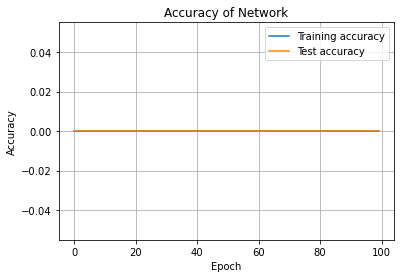

Accuracy of the network on the test point clouds: 0 %


In [2]:
############################################################

net = PointNetCls(k=1)


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

nepochs = 100

train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    epoch_train_acc = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        _, train_predicted = torch.max(outputs.data, 1)
        epoch_train_acc += (train_predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
    epoch_test_acc = 0.0
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, test_predicted = torch.max(outputs.data, 1)
        epoch_test_acc += (test_predicted == labels).sum().item()

            
    
    train_acc[epoch] = epoch_train_acc/nclouds/2
    test_acc[epoch] = epoch_test_acc/ncloudstest/2
    

print('Finished Training')

x = np.arange(nepochs)
#plt.figure(figsize=(12,8))
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, test_acc, label='Test accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy of Network')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test point clouds: %d %%' % (
    100 * correct / total))

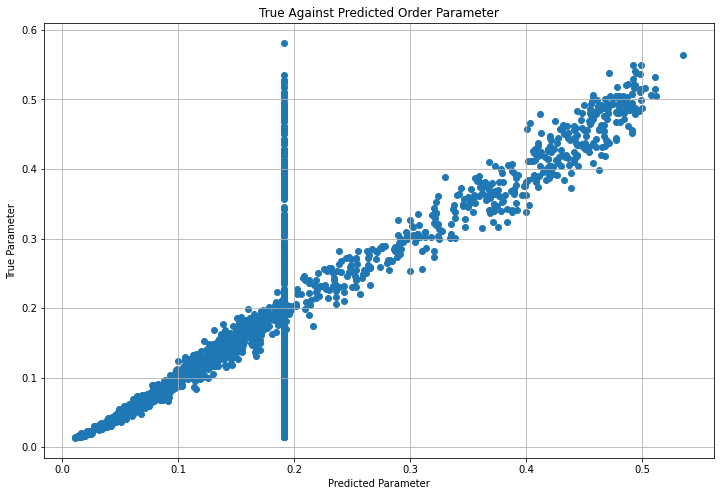

In [3]:
outputs = net(test)
x = outputs.detach().numpy()
y = labels_test
# plot the data
plt.figure(figsize=(12,8))
plt.scatter(x,y)
plt.grid()
plt.title("True Against Predicted Order Parameter")
plt.ylabel("True Parameter")
plt.xlabel("Predicted Parameter")
plt.show()

In [4]:
normal = torch.randn(nclouds, npoints, 1)
multip = np.linspace(0.1,2,20)
def shaker(vect):
    k = 0
    for i in range(len(vect)):
        vect[i] *= multip[k]
        k += 1
        k = k % 20
    return vect